In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Generating samples from a **Homogeneous** Poisson process

A Poisson process generates a series of events. For a **homogeneous** process, we describe the process by a rate of events in a time window, $\lambda$. The count (number) of events observerd is distributed as a $\text{Poisson}(\lambda T)$ where $T$ is the length of the window of observation. The time between each event ("inter-event interval") is distributed as an $\text{Exponential}(\frac{1}{\lambda T})$.

In [ ]:
# Describe our Poisson process
L = 10 # event rate (Hz )
T = 1 # duration during which events occur (s)

# We will observe the process a large number of times (to test efficiency)
K = 100000 # number of trials of random process

### Three methods:
  - Generate using a Bernoulli approximation with very small bins of time.
  - Generate ISIs from an exponential RV.
  - Generate using Poisson and Uniform trick

In [4]:
%%time
# Generating using bernoulli approximation
nbins = 1000

RateMatrix = np.ones((nbins,K)) * L / T / nbins

Data = np.random.rand(nbins,K) < RateMatrix


CPU times: user 1.05 s, sys: 256 ms, total: 1.31 s
Wall time: 1.31 s


In [5]:
%%time
# Generate using exponential RV
spiketimes = []
for k in range(K):
    sample = np.random.exponential(1/L,50) ## NOTE - 50 might not be enough!!
    assert(np.sum(sample) > T)
    if (sample[0] > T): # (We observed no events)
        spiketimes.append([])
    else:
        lastindex = np.argwhere(np.cumsum(sample) < T)[-1][0]
        spiketimes.append(np.cumsum(sample[:lastindex]))
        


CPU times: user 1.39 s, sys: 7.64 ms, total: 1.4 s
Wall time: 1.4 s


In [14]:
%%time
# Generate using Poisson and Uniform trick

Events = np.random.poisson(L,K)
spiketimes = []
for k in range(K):
    spiketimes.append(np.sort(np.random.rand(Events[k])*T))


CPU times: user 394 ms, sys: 0 ns, total: 394 ms
Wall time: 395 ms


(0, 1)

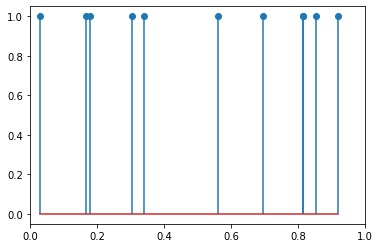

In [100]:
# Show one example event
plt.stem(spiketimes[0],np.ones(len(spiketimes[0])), use_line_collection=True)
plt.gca().set_xlim(0,T)

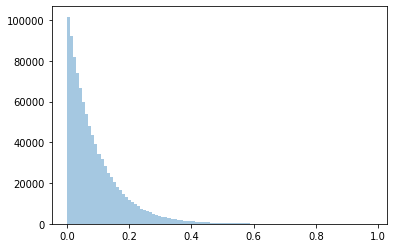

In [34]:
# Show that our events have exponential ISIs
ISIs = []
for k in range(K):
    if len(spiketimes[k]) == 0:
        continue
    ISIs.append(spiketimes[k][0])
    ISIs.extend(np.diff(np.array(spiketimes[k])).tolist())

import seaborn as sns    
sns.distplot(np.array(ISIs),100, kde=False);

<BarContainer object of 100 artists>

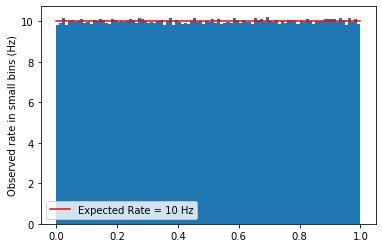

In [90]:
# Show something more interesting - that our events are equally likely across T

AllEventTimes = np.hstack(spiketimes)
nHistBins = 100
HistBins = np.linspace(0,T,nHistBins + 1)
BinDuration = T/nHistBins
vals, bin_edges = np.histogram(AllEventTimes,bins=HistBins)

EventRate = vals / K / HistBinSize # Number of events observed in each bin / Number of Observations / BinDuration

plt.plot(HistBins,np.ones(HistBins.shape) * L, 'r', label='Expected Rate = 10 Hz')
plt.gca().set_ylabel('Observed rate in small bins (Hz)')
plt.gca().legend()
plt.bar(HistBins[:-1] + BinDuration/2, EventRate ,width=BinDuration)


# Generating samples from an **Inhomogeneous** Poisson process

### Three methods:
  - Generate using a Bernoulli approximation with very small bins of time. *(Still works!)*
  - Generate using a homogeneous Poisson process and *deletion*
  - Generate ISIs from an exponential RV and apply the time rescaling theorem **not shown**

In [43]:
# Let's define our rate function to be a ramp
def rate(t):
    return 10*t

### Inhomogeneous Poisson Process Method 1: Bernouli approximation

In [102]:
%%time
# Generating using bernoulli approximation
nbins = 1000

DeltaT = 1/nbins

BinCenters = np.arange(0,1,DeltaT) + DeltaT/2

RateVector = rate(BinCenters) * DeltaT

Data = np.random.rand(nbins,K).T < RateVector

inh_spiketimes_bernoulli  = []
for k in range(K):
    inh_spiketimes_bernoulli.append(np.nonzero(Data[k,:])[0]/nbins*T)

CPU times: user 2.41 s, sys: 188 ms, total: 2.59 s
Wall time: 2.59 s


<BarContainer object of 100 artists>

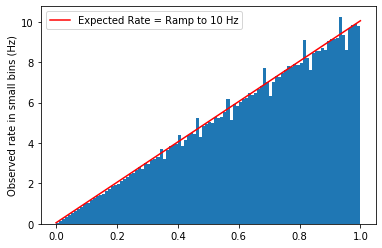

In [91]:
# Plot observed event rate in small bins

AllInhEventTimes = np.hstack(inh_spiketimes_bernoulli)

nHistBins = 100
HistBins = np.linspace(0,T,nHistBins + 1)
BinDuration = T/nHistBins
vals, bin_edges = np.histogram(AllInhEventTimes,bins=HistBins)

EventRate = vals / K / HistBinSize # Number of events observed in each bin / Number of Observations / BinDuration

plt.plot(HistBins,rate(HistBins+BinDuration/2), 'r', label='Expected Rate = Ramp to 10 Hz')
plt.gca().set_ylabel('Observed rate in small bins (Hz)')
plt.gca().legend()
plt.bar(HistBins[:-1] + BinDuration/2, EventRate ,width=BinDuration)

### Inhomogeneous Poisson Process Method 2: Deletion!

In [103]:
%%time
# Generate using Poisson and Uniform trick

# First generate a homogeneous Poisson process with a rate at least as big as the maximum
#   Inhomogeneous rate
MaximumRate = 11 # You have to know this!

Events = np.random.poisson(MaximumRate,K)
spiketimes = []
for k in range(K):
    spiketimes.append(np.sort(np.random.rand(Events[k])*T))

inh_spiketimes_deletion  = []    
# Then, go through each spike and potentially delete it!!
for k in range(K):
    RateAtSpikeTime = rate(spiketimes[k])
    DeletionRand = np.random.rand(*RateAtSpikeTime.shape)
    inh_spiketimes_deletion.append( 
        np.delete(spiketimes[k], np.argwhere(DeletionRand > RateAtSpikeTime/MaximumRate)) )
    

CPU times: user 5.55 s, sys: 5.45 ms, total: 5.56 s
Wall time: 5.55 s


<BarContainer object of 100 artists>

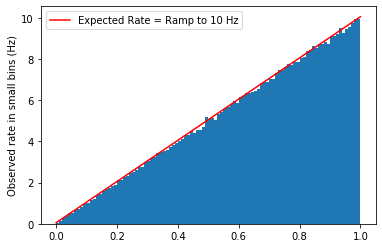

In [99]:
# Plot observed event rate in small bins

AllInhEventTimes = np.hstack(inh_spiketimes_deletion)

nHistBins = 100
HistBins = np.linspace(0,T,nHistBins + 1)
BinDuration = T/nHistBins
vals, bin_edges = np.histogram(AllInhEventTimes,bins=HistBins)

EventRate = vals / K / HistBinSize # Number of events observed in each bin / Number of Observations / BinDuration

plt.plot(HistBins,rate(HistBins+BinDuration/2), 'r', label='Expected Rate = Ramp to 10 Hz')
plt.gca().set_ylabel('Observed rate in small bins (Hz)')
plt.gca().legend()
plt.bar(HistBins[:-1] + BinDuration/2, EventRate ,width=BinDuration)